In [1]:
!pip install silero_vad

In [2]:
import pyaudio
import numpy as np
import threading
from silero_vad import VADIterator,load_silero_vad
from IPython.display import Audio, display

In [3]:
# 初始化VAD迭代器
model = load_silero_vad(onnx=True)
vad_iterator = VADIterator(model, threshold=0.5)

In [4]:

# 配置音频流
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 512  # 32ms @ 16kHz
import time

continue_recording = True

def stop():
    input("请输入任何内容来停止记录:")
    global continue_recording
    continue_recording = False
    print("停止记录中...")
    time.sleep(3) # 延迟3秒钟，防止stream.read阻塞
    stream.stop_stream()
    stream.close()
    audio.terminate()
    print("已停止记录")

def start_recording():
    global audio
    audio = pyaudio.PyAudio()
    global stream
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

    global stop_listener
    stop_listener = threading.Thread(target=stop)
    stop_listener.start()
    global frames
    frames = []
    while continue_recording:
        data = stream.read(CHUNK)
        # 转换为模型输入格式
        audio_chunk = np.frombuffer(data, dtype=np.int16).astype(np.float32) / 32768.0
        frames.append(data)
        # 处理音频块
        result = vad_iterator(audio_chunk, return_seconds=True)
        if result:
            if 'start' in result:
                print(f"语音开始: {result['start']:.2f}s")
            else:
                print(f"语音结束: {result['end']:.2f}s")
    #stop_listener.join()

In [5]:
start_recording()

语音开始: 2.40s
语音结束: 4.10s
语音开始: 8.70s
语音结束: 10.80s
语音开始: 15.30s
语音结束: 18.70s


请输入任何内容来停止记录: 1


停止记录中...


In [6]:
# 合并所有音频数据
audio_bytes = b''.join(frames)
# 转换为 numpy int16 数组
audio_int16 = np.frombuffer(audio_bytes, dtype=np.int16)
# 转换为 float32 并归一化
audio_float32 = audio_int16.astype(np.float32) / 32768.0

print("==== 完整录音 ====")
display(Audio(audio_float32, rate=RATE))

==== 完整录音 ====


In [7]:
import soundfile as sf
import librosa
import numpy as np
import matplotlib.pyplot as plt
from silero_vad import VADIterator,load_silero_vad,get_speech_timestamps

In [8]:
y = audio_float32
sr = RATE
# ========= 使用 Silero VAD 获取语音段 =========
speech_timestamps = get_speech_timestamps(y, model, sampling_rate=RATE)

# 结果形式为：
# [{'start':1600,'end':4800}, {'start':7100,'end':10200}, ...]


# ========= 转换为秒 =========
segments_speech = [
    (ts["start"] / sr, ts["end"] / sr)
    for ts in speech_timestamps
]

print("==== 有声音的音频段落 ====")
for i, (s, e) in enumerate(segments_speech):
    print(f"Speech {i+1}: start={s:.2f}s, end={e:.2f}s, duration={e-s:.2f}s")


==== 有声音的音频段落 ====
Speech 1: start=2.37s, end=4.09s, duration=1.72s
Speech 2: start=8.71s, end=10.85s, duration=2.14s
Speech 3: start=15.33s, end=18.72s, duration=3.39s


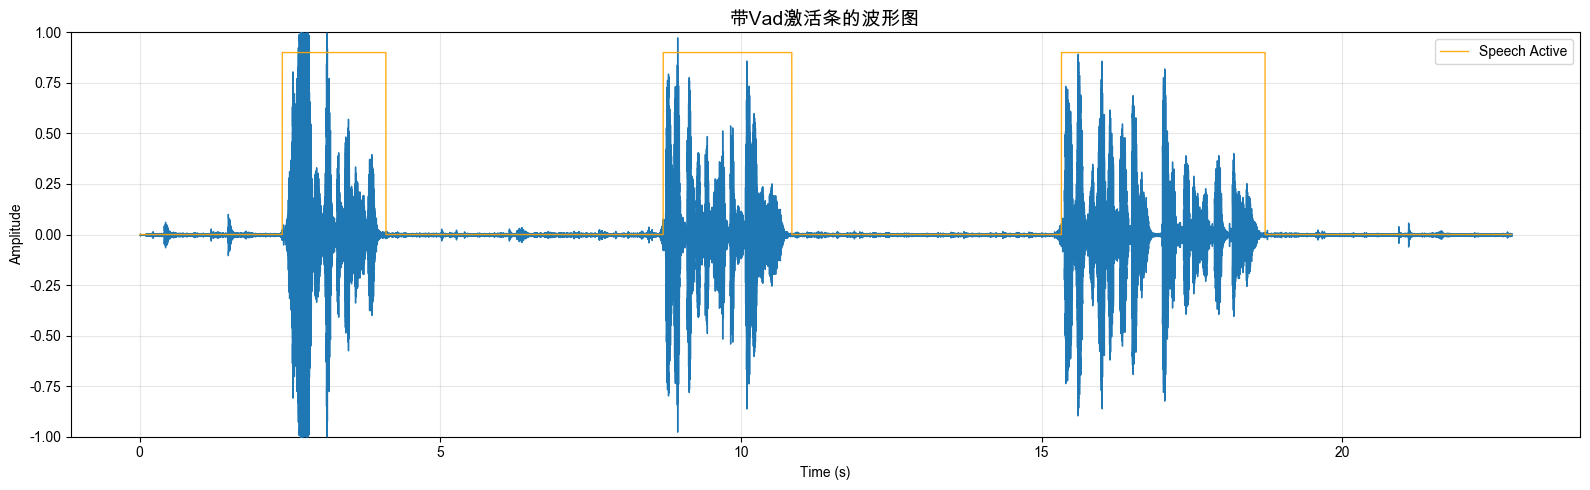


==== 播放每段语音并绘制波形图 ====

语音段 1: 2.37s ~ 4.09s (duration=1.72s)


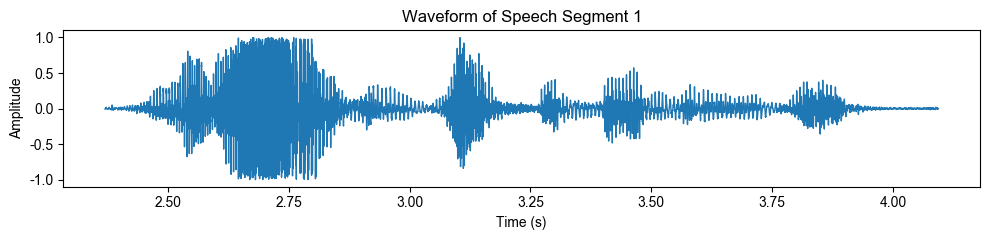


语音段 2: 8.71s ~ 10.85s (duration=2.14s)


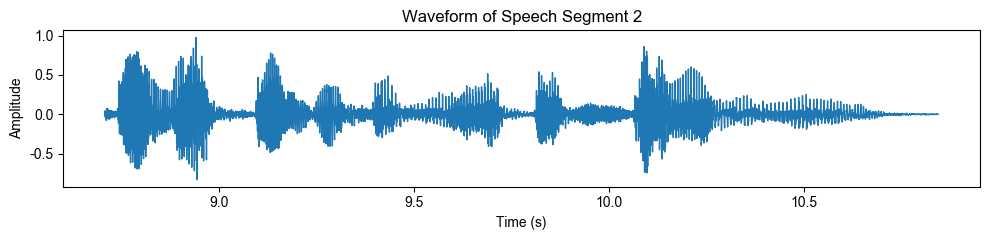


语音段 3: 15.33s ~ 18.72s (duration=3.39s)


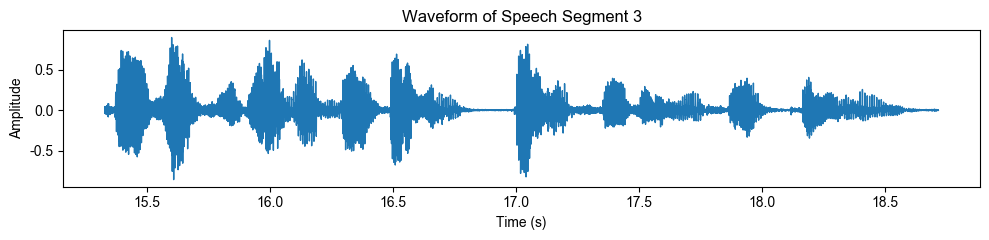

In [9]:
plt.figure('impulse',figsize=(16, 5))

# 1. 先画波形
librosa.display.waveshow(y, sr=sr, zorder=5)

# 2. 绘制语音活性指示条
#   语音的地方画 y=0.9 的橘色横线，静音画 y=0 的细线(高低横线活性条)
duration = len(y) / sr
time_axis = np.linspace(0, duration, len(y))

# 创建一个全为0的数组，表示默认静音
activity = np.zeros_like(y)

# 把所有有语音的样本位置设为 0.9
for start_sec, end_sec in segments_speech:
    start_sample = int(start_sec * sr)
    end_sample   = int(end_sec * sr)
    activity[start_sample:end_sample] = 0.9

# 画出这个“活性条”，用粗线条盖在最上面
plt.plot(time_axis, activity, color='orange', linewidth=1, alpha=0.9, label='Speech Active', zorder=10)
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC', 'Heiti TC', 'Songti SC', 'STFangsong']
plt.rcParams['axes.unicode_minus'] = False            # 用来正常显示负号

plt.title("带Vad激活条的波形图", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(-1.0, 1.0)  # 保持波形完整显示
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ========= 播放每段语音，并画该段波形 =========
print("\n==== 播放每段语音并绘制波形图 ====")
for i, (s, e) in enumerate(segments_speech):
    print(f"\n语音段 {i+1}: {s:.2f}s ~ {e:.2f}s (duration={e-s:.2f}s)")

    start_sample = int(s * sr)
    end_sample = int(e * sr)
    segment_data = y[start_sample:end_sample]

    # 播放
    display(Audio(segment_data, rate=sr))

    # 局部波形图
    plt.figure(figsize=(10, 2.5))
    t = np.linspace(s, e, len(segment_data))
    plt.plot(t, segment_data, linewidth=1)
    plt.title(f"Waveform of Speech Segment {i+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()